**Load libraries**

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from google.colab.patches import cv2_imshow

import cv2
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix,classification_report

from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)

**Mount google drive**

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load images,labels and print the shape of dataset**

In [58]:
images = np.load('/content/drive/MyDrive/images.npy', mmap_mode='r+')

In [59]:
images.shape

(4750, 128, 128, 3)

There are 4750 images of 128x128 pixels in RGB scale.

In [60]:
imageLabels = pd.read_csv('/content/drive/MyDrive/Labels.csv')

In [61]:
imageLabels.head()

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill


In [62]:
imageLabels.shape

(4750, 1)

In [63]:
imageLabels.nunique()

Label    12
dtype: int64

There are 12 unique labels.

In [64]:
imageLabels['Label'].unique()

array(['Small-flowered Cranesbill', 'Fat Hen', 'Shepherds Purse',
       'Common wheat', 'Common Chickweed', 'Charlock', 'Cleavers',
       'Scentless Mayweed', 'Sugar beet', 'Maize', 'Black-grass',
       'Loose Silky-bent'], dtype=object)

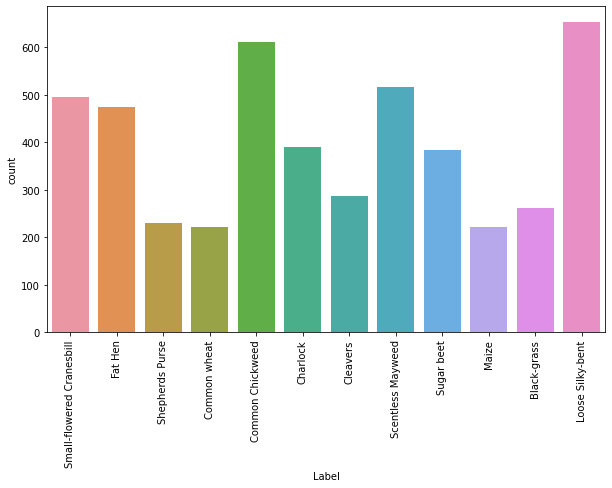

In [65]:
plt.figure(figsize=(10,6))
sns.countplot(imageLabels['Label']);
plt.xticks(rotation = 90);

**Visualize the images**

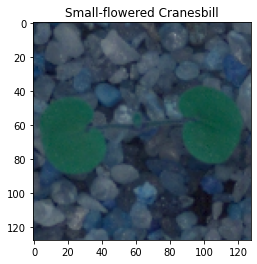

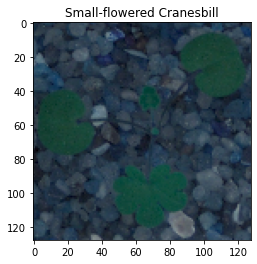

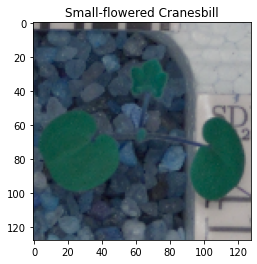

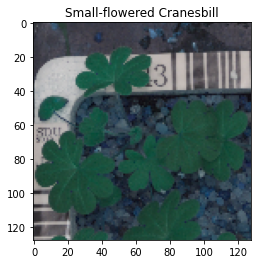

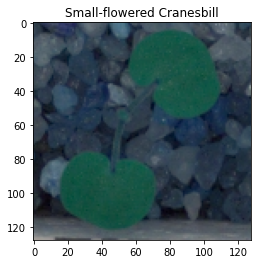

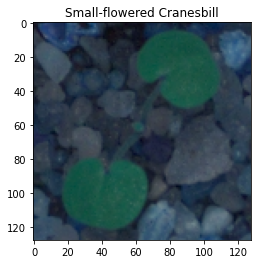

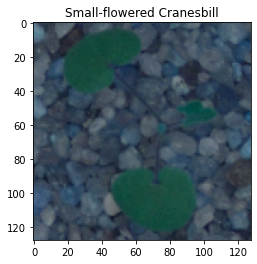

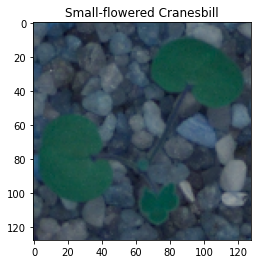

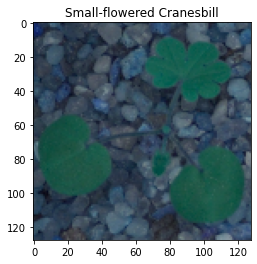

In [66]:
for i in range(9):
  plt.title(imageLabels.at[i,'Label'])
  plt.imshow(images[i], cmap='gray')
  plt.show()

**Normalization**

In [67]:
images = images.astype('float32')/255.0

In [68]:
type(images)

numpy.ndarray

**Gaussian Blurring**

In [69]:
imageArr = []
for image in images:
  gaussian_img = cv2.GaussianBlur(image,(5,5),0)
  imageArr.append(gaussian_img)

**Visualize after preprocessing**

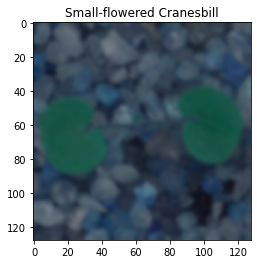

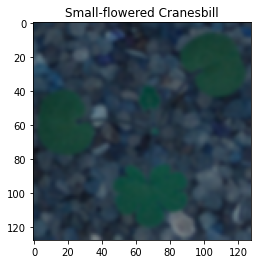

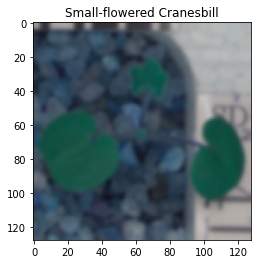

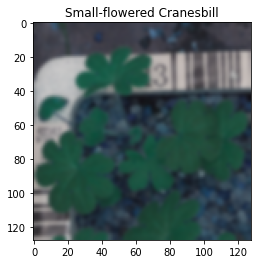

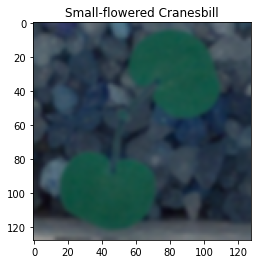

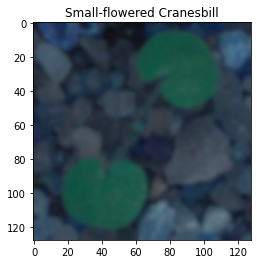

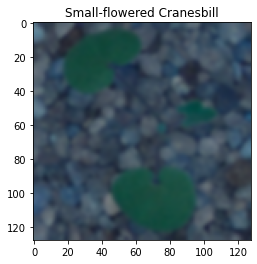

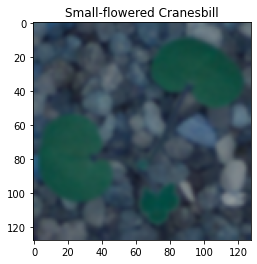

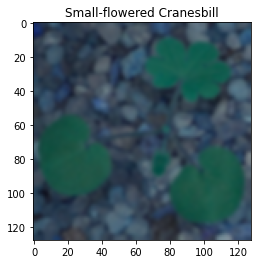

In [70]:
for i in range(9):
  plt.title(imageLabels.at[i,'Label'])
  plt.imshow(imageArr[i], cmap='gray')
  plt.show()

In [71]:
X = np.array(imageArr)

**Convert to one hot vectors**

In [72]:
le = LabelEncoder()
y = le.fit_transform(imageLabels)
y = to_categorical(y,12)

In [73]:
type(y)

numpy.ndarray

In [74]:
y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

**Split into train/test/validation sets**

In [75]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=7)
X_val,X_test,y_val,y_test = train_test_split(X_test,y_test,test_size=0.5,random_state=7)

In [76]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(3325, 128, 128, 3)
(713, 128, 128, 3)
(712, 128, 128, 3)
(3325, 12)
(713, 12)
(712, 12)


Input is already in desired shape.

**Data Augmentation to reduce overfitting**

In [77]:
from keras.preprocessing.image import ImageDataGenerator

In [78]:
train_datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2,  
        horizontal_flip=True,
        vertical_flip=False)


train_datagen.fit(X_train)

**Build CNN**

In [79]:
model = Sequential()

model.add(Conv2D(64,(3,3),padding='valid',input_shape=(128, 128, 3),activation='relu'))
model.add(BatchNormalization())
#model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
#model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(units=512,activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(units=128,activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(12,activation='softmax'))


In [80]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

**Fit the model**

In [81]:
early_stopping_cb = EarlyStopping(monitor="val_loss", patience=10,min_delta=0.001,
                                  restore_best_weights=True)

history = model.fit_generator(train_datagen.flow(X_train,y_train,
          batch_size=32),
          epochs=100,
          validation_data=(X_val,y_val),
          steps_per_epoch = len(X_train)/32,
          callbacks=[early_stopping_cb])

Epoch 1/100
103/103 [==============================] - 17s 154ms/step - loss: 2.7523 - accuracy: 0.1837 - val_loss: 5.4737 - val_accuracy: 0.1320
Epoch 2/100
103/103 [==============================] - 16s 153ms/step - loss: 1.8262 - accuracy: 0.4098 - val_loss: 4.3975 - val_accuracy: 0.1320
Epoch 3/100
103/103 [==============================] - 16s 152ms/step - loss: 1.5420 - accuracy: 0.4695 - val_loss: 7.2488 - val_accuracy: 0.1320
Epoch 4/100
103/103 [==============================] - 16s 151ms/step - loss: 1.3525 - accuracy: 0.5399 - val_loss: 6.3417 - val_accuracy: 0.1671
Epoch 5/100
103/103 [==============================] - 16s 152ms/step - loss: 1.2937 - accuracy: 0.5616 - val_loss: 3.2705 - val_accuracy: 0.2191
Epoch 6/100
103/103 [==============================] - 16s 153ms/step - loss: 1.1538 - accuracy: 0.6156 - val_loss: 1.4920 - val_accuracy: 0.4958
Epoch 7/100
103/103 [==============================] - 16s 153ms/step - loss: 1.0952 - accuracy: 0.6208 - val_loss: 1.2545 -

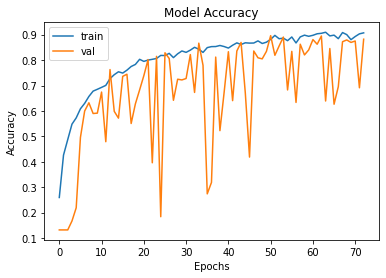

In [82]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

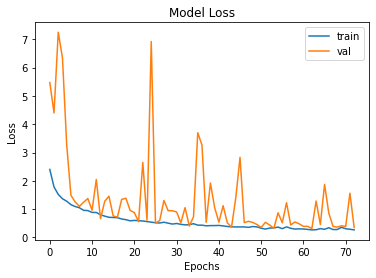

In [83]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

**Evaluate the model**

In [84]:
model.evaluate(X_test, y_test)

23/23 [==============================] - 1s 31ms/step - loss: 0.3027 - accuracy: 0.9032


[0.30269578099250793, 0.9032257795333862]

In [85]:
y_pred = model.predict(X_test) 
y_pred = np.round(y_pred)

In [86]:
y_pred

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [87]:
y_test

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [88]:
print(classification_report(np.argmax(y_test,axis=-1),np.argmax(y_pred,axis=-1)))

              precision    recall  f1-score   support

           0       0.45      0.87      0.59        38
           1       0.98      0.93      0.96        58
           2       0.92      0.98      0.95        47
           3       0.98      0.92      0.95        86
           4       0.93      0.83      0.88        30
           5       0.98      0.97      0.97        87
           6       0.91      0.66      0.77        95
           7       0.88      0.97      0.93        38
           8       0.94      0.98      0.96        86
           9       0.96      0.79      0.87        29
          10       1.00      0.98      0.99        65
          11       0.94      0.93      0.93        54

    accuracy                           0.90       713
   macro avg       0.91      0.90      0.90       713
weighted avg       0.92      0.90      0.91       713



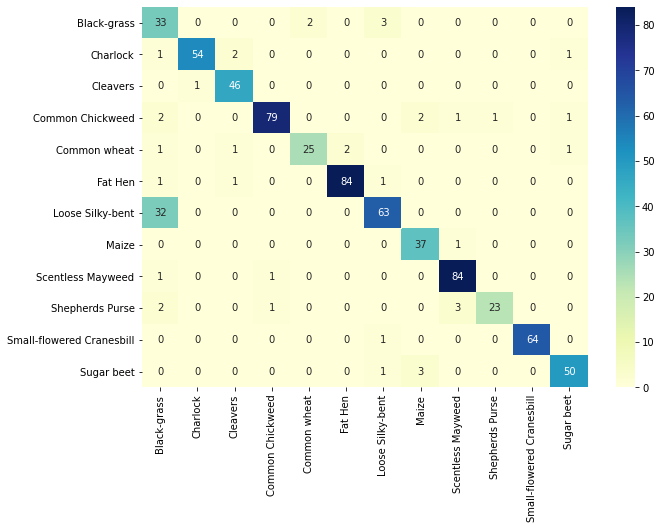

In [89]:
conf = confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1))
conf_df = pd.DataFrame(conf, index = [i for i in le.classes_],
                     columns = [i for i in le.classes_])
conf_df = pd.DataFrame(conf_df)
plt.figure(figsize = (10,7))
sns.heatmap(conf_df, annot=True, fmt='d',cmap='YlGnBu');

**Visualize predictions for x_test[2], x_test[3], x_test[33], x_test[36], x_test[59]**

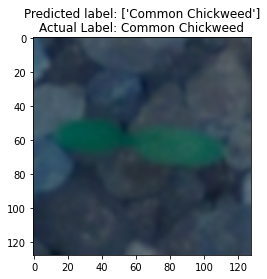

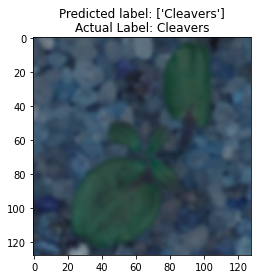

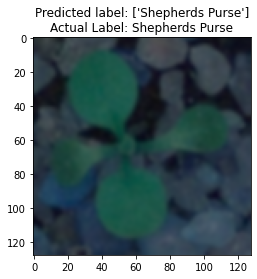

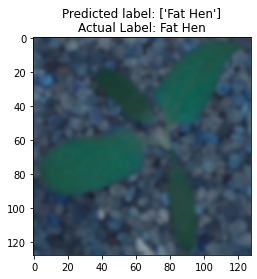

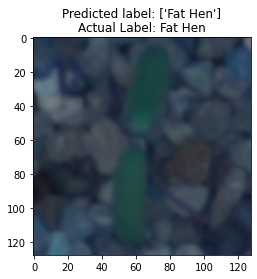

In [90]:
imageIndexList = [2,3,33,36,59]
for i in imageIndexList:
  y_pred = model.predict(X_test[i].reshape(1,128,128,3))
  #print("Predicted label:", y_pred.argmax())
  #print("Actual Label:", y_test[i].argmax())
  plt.title("Predicted label: " + str(le.inverse_transform(np.argmax(y_pred,axis=1)))
   + '\n' + "Actual Label: " + str(le.classes_[y_test[i].argmax()]))
  plt.imshow(X_test[i], cmap='gray')
  plt.show()
  print("====================================")

This model is giving us 90% accuracy on test data.